## 最適化問題

$$ \min_h \|\bm{g}-F^\top \bm{h}\|_2^2+\lambda_1\|\bm{h}\|_{1,2}^2 + \lambda_2\|D\bm{h}\|_{1,2}$$


In [1]:
import os
import re
import random
import time
from typing import Callable
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import sparse

In [2]:
# パラメータ設定
n = 64
m = 128
N = n**2
M = m**2
LAMBDA1 = 1
LAMBDA2 = 1
SEED = 3
RATIO = 0.05
DATA_PATH = "../../OneDrive - m.titech.ac.jp/Lab/data"
IMG_NAME = "hadamard"
DIRECTORY = DATA_PATH + "/240718"
SETTING = f"{IMG_NAME}_l1_p-{int(100*RATIO)}_lmd1-{int(LAMBDA1)}_lmd2-{int(LAMBDA2)}"

if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
if not os.path.exists(DIRECTORY + "/systemMatrix"):
    os.makedirs(DIRECTORY + "/systemMatrix")

Di = sparse.eye(M, format='csr') - sparse.eye(M, k=m, format='csr')
Di[-m:, :] = 0

Dj = sparse.eye(M, format='csr') - sparse.eye(M, k=1, format='csr')
for p in range(1, m + 1):
    Dj[m * p - 1, m * p - 1] = 0
    if p < m:
        Dj[m * p - 1, m * p] = 0

Dk = sparse.eye(N, format='csr') - sparse.eye(N, k=n, format='csr')
Dk = sparse.csr_matrix(Dk[:n * (n - 1), :N])
Dk = sparse.vstack([Dk, sparse.csr_matrix((n, N))])

Dl = sparse.eye(N, format='csr') - sparse.eye(N, k=1, format='csr')
for p in range(1, n + 1):
    Dl[n * p - 1, n * p - 1] = 0
    if p < n:
        Dl[n * p - 1, n * p] = 0

Di_gpu = cp.sparse.csr_matrix(Di).astype(cp.float32)
Dj_gpu = cp.sparse.csr_matrix(Dj).astype(cp.float32)
Dk_gpu = cp.sparse.csr_matrix(Dk).astype(cp.float32)
Dl_gpu = cp.sparse.csr_matrix(Dl).astype(cp.float32)

c:\Users\ohara\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [3]:
def matrix2vectorNp(matrix: np.ndarray) -> np.ndarray:
    return matrix.reshape(-1, 1, order="F").flatten().astype(np.float32)


def matrix2vectorCp(matrix: cp.ndarray) -> cp.ndarray:
    return matrix.reshape(-1, 1, order="F").flatten().astype(cp.float32)


def vector2matrixNp(vector: np.ndarray, s: int, t: int) -> np.ndarray:
    return vector.reshape(s, t, order="F").astype(np.float32)


def vector2matrixCp(vector: cp.ndarray, s: int, t: int) -> cp.ndarray:
    return vector.reshape(s, t, order="F").astype(cp.float32)


def mult_mass(X: cp.ndarray, h: cp.ndarray, M: int) -> cp.ndarray:
    F_gpu = X.T.astype(cp.float32)
    H_gpu = cp.asarray(h.reshape(M, -1, order="F"))
    res_gpu = H_gpu @ F_gpu
    return matrix2vectorCp(res_gpu)


def mult_Dijkl(h: cp.ndarray) -> cp.ndarray:
    H = vector2matrixCp(h, M, N)
    res_gpu = cp.hstack([Di_gpu @ H, Dj_gpu @ H, H @ Dk_gpu.T, H @ Dl_gpu.T])
    return matrix2vectorCp(res_gpu)


def mult_DijklT(y: cp.ndarray) -> cp.ndarray:
    y1 = y[: M * N]
    y2 = y[M * N : 2 * M * N]
    y3 = y[2 * M * N : 3 * M * N]
    y4 = y[3 * M * N :]
    Y1 = vector2matrixCp(y1, M, N)
    Y2 = vector2matrixCp(y2, M, N)
    Y3 = vector2matrixCp(y3, M, N)
    Y4 = vector2matrixCp(y4, M, N)

    res_gpu = Di_gpu.T @ Y1 + Dj_gpu.T @ Y2 + Y3 @ Dk_gpu.T + Y4 @ Dl_gpu.T
    return matrix2vectorCp(res_gpu)


def images_to_matrix(folder_path, convert_gray=True, rand=True, ratio=RATIO):
    files = os.listdir(folder_path)
    files.sort(key=lambda f: int(re.search(f"{IMG_NAME}_(\d+).png", f).group(1)))
    if rand:
        random.seed(SEED)
        random.shuffle(files)

    total_files = len(files)
    number_of_files_to_load = int(total_files * ratio)
    selected_files = files[:number_of_files_to_load]
    selected_files.sort(key=lambda f: int(re.search(f"{IMG_NAME}_(\d+).png", f).group(1)))

    images = []
    use_list = []

    for file in selected_files:
        index = int(re.sub(r"\D", "", file))
        use_list.append(index)
        img = Image.open(os.path.join(folder_path, file))
        if convert_gray:
            img = img.convert("L")
        img_array = np.asarray(img).flatten()
        img_array = img_array / 255
        images.append(img_array)

    return np.column_stack(images), use_list

In [4]:
def prox_l122(y: cp.ndarray, gamma: float) -> cp.ndarray:
    Y = cp.asarray(vector2matrixCp(y, M, N))
    l1_norms = cp.sum(cp.absolute(Y), axis=1)
    factor = (2 * gamma) / (1 + 2 * gamma * N)
    X = cp.zeros_like(Y)
    X = cp.sign(Y) * cp.maximum(cp.absolute(Y) - factor * l1_norms[:, None], 0)
    return matrix2vectorCp(X)


def prox_tv(y: cp.ndarray, gamma: float) -> cp.ndarray:
    Dx_norm = cp.linalg.norm(y.reshape(-1, 4, order="F"), axis=1).astype(cp.float32)
    Dx_norm = cp.tile(Dx_norm[:, None], (1, 4))

    prox = cp.maximum(1 - gamma / Dx_norm, 0) * y.reshape(-1, 4, order="F")
    prox = prox.reshape(-1, order="F")

    return prox


def prox_conj(prox: Callable[[cp.ndarray, float], cp.ndarray], x: cp.ndarray, gamma: float) -> cp.ndarray:
    """Conjugate proximal operator."""
    return x - gamma * prox(x / gamma, 1 / gamma)


def primal_dual_splitting(
    X: cp.ndarray,
    g: cp.ndarray,
    lambda1: float,
    lambda2: float,
    max_iter: int = 1000,
    tol: float = 1e-2,
) -> tuple[np.ndarray, dict]:
    """
    Solve the optimization problem:
    min_h ||g-Xh||_2^2 + lambda1 P(h) + lambda2 ||Dh||_{1,2}
    using the primal-dual splitting method.

    Args:
        X (cp.ndarray): Matrix X in the problem formulation.
        g (cp.ndarray): Vector g in the problem formulation.
        lambda1 (float): Regularization parameter for L1 norm of h.
        lambda2 (float): Regularization parameter for L1 norm of Dh.

    Returns:
        tuple[np.ndarray, dict]: Solution h and a dictionary containing additional information.
    """
    h = cp.zeros(M * N)
    y = cp.zeros(4 * M * N)

    # Compute Lipschitz constant of grad_f
    # tau = 1.0 / (np.linalg.norm(X, 2) ** 2)  # 1 / Compute Lipschitz constant of grad_f
    # sigma = 1.0 / ((2 * M * N * 2) ** 2)  # 1 / l2 norm of Dij ^ 2
    tau = 1 / (4096 * 3)
    sigma = 1 / (4096 * 3)
    print(f"tau={tau}, sigma={sigma}")

    for k in range(max_iter):
        start = time.perf_counter()
        h_old = cp.asarray(h.copy())
        y_old = cp.asarray(y.copy())

        # Update primal variable h
        grad = mult_mass(X.T, (mult_mass(X, h_old, M) - g), M)
        buf1 = h_old - tau * (grad - mult_DijklT(y_old))
        del grad
        h = prox_l122(buf1, tau * lambda1)
        del buf1

        # Update dual variable y
        y = prox_conj(prox_tv, y_old + sigma * mult_Dijkl(2 * h - h_old), sigma / lambda2)

        end = time.perf_counter()
        # Check convergence
        if k % 50 == 0:
            primal_residual = cp.linalg.norm(h - h_old)
            dual_residual = cp.linalg.norm(y - y_old)
            print(f"iter={k}, primal_res={primal_residual:.4f}, dual_res={dual_residual:.4f}, time={end-start:.4f}")
            if primal_residual < tol and dual_residual < tol:
                break
        else:
            print(f"iter={k}, time={end-start:.4f}")

    info = {
        "iterations": k + 1,
        "primal_residual": primal_residual,
        "dual_residual": dual_residual,
    }

    return cp.asnumpy(h), info

In [5]:
# load images
G, _ = images_to_matrix(f"{DATA_PATH}/{IMG_NAME}{n}_cap_R_230516_128/")
F, _ = images_to_matrix(f"{DATA_PATH}/{IMG_NAME}{n}_input/")
print("K=", F.shape[1])
white_img = Image.open(f"{DATA_PATH}/{IMG_NAME}{n}_cap_R_230516_128/{IMG_NAME}_1.png")
white_img = white_img.convert("L")
white_img = np.asarray(white_img) / 255
white = white_img.flatten()
white = white[:, np.newaxis]
H1 = np.tile(white, F.shape[1])
F_hat = 2 * F - 1
g = matrix2vectorNp(2 * G - H1)

K= 409


In [6]:
# h, info = primal_dual_splitting(F_hat.T, g, LAMBDA1, LAMBDA2)
F_hat_T_gpu = cp.asarray(F_hat.T).astype(cp.float32)
g_gpu = cp.asarray(g).astype(cp.float32)
h, info = primal_dual_splitting(F_hat_T_gpu, g_gpu, LAMBDA1, LAMBDA2)

tau=8.138020833333333e-05, sigma=8.138020833333333e-05
iter=0, primal_res=0.7099, dual_res=0.0002, time=18.2587
iter=1, time=0.3465
iter=2, time=0.0036
iter=3, time=0.0031
iter=4, time=0.0030
iter=5, time=0.0030
iter=6, time=0.0032
iter=7, time=0.0033
iter=8, time=0.0032
iter=9, time=0.0033
iter=10, time=0.0034
iter=11, time=1.0740
iter=12, time=3.3397
iter=13, time=6.7065
iter=14, time=2.5544
iter=15, time=12.2127
iter=16, time=12.7280
iter=17, time=11.7201
iter=18, time=8.7402
iter=19, time=6.7213
iter=20, time=2.8307
iter=21, time=6.7327
iter=22, time=2.5472
iter=23, time=6.7290
iter=24, time=2.5825
iter=25, time=6.7428
iter=26, time=2.5584
iter=27, time=6.7419
iter=28, time=2.8261
iter=29, time=6.7315
iter=30, time=2.5650
iter=31, time=6.7304
iter=32, time=2.8235
iter=33, time=6.7385
iter=34, time=5.3236
iter=35, time=2.8005
iter=36, time=10.9034
iter=37, time=16.0179
iter=38, time=17.5464
iter=39, time=16.3540
iter=40, time=4.9738
iter=41, time=7.3796
iter=42, time=5.6473
iter=43,

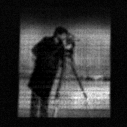

In [7]:
H = vector2matrixNp(h, M, N)
np.save(f"{DIRECTORY}/systemMatrix/H_matrix_{SETTING}.npy", H)

sample_image = Image.open(f"{DATA_PATH}/sample_image64/Cameraman64.png").convert('L')
sample_image = np.asarray(sample_image).flatten() / 255

Hf = H @ sample_image
Hf_img = Hf.reshape(m, m)
Hf_img = np.clip(Hf_img, 0, 1)
Hf_pil = Image.fromarray((Hf_img * 255).astype(np.uint8), mode='L')

FILENAME = f"Cameraman64_{SETTING}.png"
fig, ax = plt.subplots(figsize=Hf_img.shape[::-1], dpi=1, tight_layout=True)
ax.imshow(Hf_pil, cmap='gray')
ax.axis('off')
fig.savefig(f"{DIRECTORY}/{FILENAME}", dpi=1)
plt.show()

In [8]:
H_true = np.load(f"{DATA_PATH}/systemMatrix/H_matrix_true.npy")
rem = np.linalg.norm(H_true - H, "fro")
print(rem)

1.9054857919598747
